# Семинар 14

# Метод Ньютона: дорого и быстро

## На прошлом семинаре...

1. Методы спуска
2. Направление убывания
3. Градиентный метод
4. Правила выбора шага
5. Теоремы сходимости
6. Эксперименты

## Недостатки градиентного спуска

- Линейная скорость сходимости
- Зависимость от числа обусловнности гессиана

Можно ли их одновременно преодолеть?

## Мотивация метода Ньютона
Рассмотрим задачу
$$
\min\limits_{x\ \in \mathbb{R}^n} f(x).
$$

- Градиентный спуск $\equiv$ **линейная** аппроксимация $f$
- Метод Ньютона $\equiv$ **квадратичная** аппроксимация $f$:
$$
f(x + h) \approx f(x) + \langle f'(x), h \rangle + \frac{1}{2}h^{\top}f''(x)h \to \min_{h}
$$
Из необходимого условия минимума:
$$
f'(x) + f''(x) h = 0, \qquad h^* = -(f''(x))^{-1} f'(x)
$$


### Является ли найденное направление направлением убывания?

Проверим знак скалярного произведения $\langle f'(x), h^* \rangle$.
$$
\langle f'(x), h^* \rangle = -(f')^{\top}(x) (f''(x))^{-1} f'(x) < 0 \iff f''(x) \succ 0
$$

## Метод Ньютона

- Классический метод Ньютона: $\alpha_k \equiv 1$
- Демпфированный метод Ньютона: $\alpha_k$ выбирается на каждой итерации по заданому правилу

```python
def NewtonMethod(f, x0, epsilon, **kwargs):
    x = x0
    while True:
        h = ComputeNewtonStep(x, f, **kwargs)
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            break
        alpha = SelectStepSize(x, h, f, **kwargs)
        x = x + alpha * h
    return x

```

## Теорема сходимости

**Теорема.** Пусть функция $f(x)$ такая что
- дважды дифференцируема и гессиан удовлетворяет условию Липшица с константой $M$
- существует точка локального минимума с положительно определённым гессианом
$$
f''(x^*) \succeq lI, \; l > 0
$$
- начальная точка $x_0$ достаточно близка к точки минимума, в частности
$$
\|x_0 - x^*\|_2 \leq \frac{2l}{3M}
$$

Тогда метод Ньютона сходится **квадратично**:
$$
\|x_{k+1} - x^* \|_2 \leq \dfrac{M\|x_k - x^*\|^2_2}{2 (l - M\|x_k - x^*\|_2)}
$$

## Аффинная инвариантность

Рассмотрим функцию $f(x)$ и невырожденное преобразование с матрицей $A$. 

Выясним, как изменится шаг метода Ньютона после преобразования $A$.

Пусть $x = Ay$ и $g(y) = f(Ay)$. Тогда
$$
g(y + u) \approx g(y) + \langle g'(y), u \rangle + \frac{1}{2} u^{\top} g''(y) u \to \min_{u}
$$
и
$$
u^* = -(g''(y))^{-1} g'(y) \qquad y_{k+1} = y_k - (g''(y_k))^{-1} g'(y_k)
$$
или

\begin{equation}
\begin{split}
y_{k+1} & = y_k - (A^{\top}f''(Ay_k)A)^{-1} A^{\top}f'(Ay_k)\\
& = y_k - A^{-1}(f''(Ay_k))^{-1}f'(Ay_k)
\end{split}
\end{equation}
Таким образом,
$$
Ay_{k+1} = Ay_k - (f''(Ay_k))^{-1}f'(Ay_k) \quad x_{k+1} = x_k - (f''(x_k))^{-1}f'(x_k)
$$
Следовательно, направление метода Ньютона преобразуется при линейном преобразовани так же, как и координаты!

## Вычислительная сложность и эксперименты

Узкие места метода Ньютона:

- Формирование и хранение гессиана
- Решение систем линейных уравнений
$$
f''(x_k)h = -f'(x_k)
$$

### Сравнение с градиентным спуском

Вспомним задачу нахождения аналитического центра системы неравенств $Ax \leq 1$ при условии $|x_i| \leq 1$
$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

$$
f'(x) - ? \quad f''(x) - ?
$$ 

In [22]:
import numpy as np
n = 1000
m = 200
x0 = np.zeros((n,))
A = np.random.rand(n, m) * 10

#### Точное решение с помощью CVXPy

In [23]:
import cvxpy as cvx
print cvx.installed_solvers()
x = cvx.Variable(n, 1)

obj = cvx.Minimize(cvx.sum_entries(-cvx.log(1 - A.T * x)) - 
                   cvx.sum_entries(cvx.log(1 - cvx.square(x))))
prob = cvx.Problem(obj)
prob.solve(solver="ECOS", verbose=False)
x = x.value
print "Optimal value =", prob.value

['CVXOPT', 'MOSEK', 'ECOS_BB', 'GLPK_MI', 'SCS', 'ECOS', 'GLPK', 'LS']
Optimal value = -1368.61224414


In [24]:
import numpy as np

f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), axis=1) + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

def my_callback(x, array):
    array.append(x)

In [25]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter, line_search, 
                    disp=False, callback=None, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
    while True:
        gradient = gradf(x)
        hess = hessf(x)
        h = np.linalg.solve(hess, -gradient)
        alpha = line_search(x, h, **opt_arg)
        x = x + alpha * h
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print "Current function val =", f(x)
            print "Current gradient norm = ", np.linalg.norm(gradf(x))
        if np.linalg.norm(gradf(x)) < epsilon:
            break
        if iteration >= num_iter:
            break
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    return res

In [18]:
import code

newton_conv = []
callback = lambda x: my_callback(x, newton_conv)
newton_res = Newton(f, grad_f, hess_f, x0, 1e-6, 50, code.backtracking, callback=callback, 
             method="Armijo", beta1=0.1, rho=0.9)

grad_conv = []
callback = lambda x: my_callback(x, grad_conv)
gradient_res = code.GradientDescent(f, grad_f, x0, 1e-6, 50, code.backtracking, callback=callback, 
             method="Armijo", beta1=0.1, rho=0.9)

/home/alex/anaconda2/envs/cvxpy/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


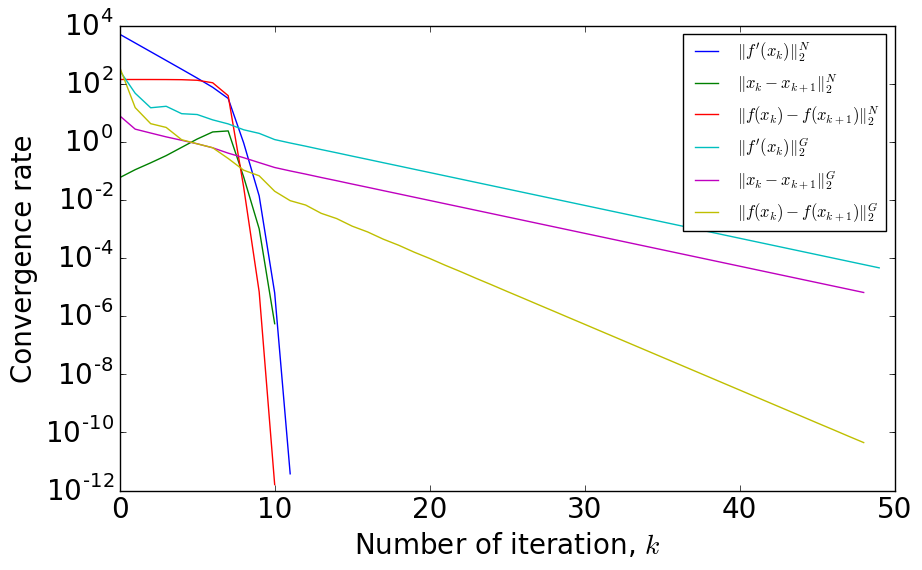

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Newton
plt.semilogy([np.linalg.norm(grad_f(x)) for x in newton_conv], label="$\| f'(x_k) \|^{N}_2$")
plt.semilogy([np.linalg.norm(np.array(newton_conv[i]) - np.array(newton_conv[i+1])) for i in xrange(len(newton_conv) - 1)], label=r"$\|x_k - x_{k+1}\|^N_2$")
plt.semilogy([np.linalg.norm(f(np.array(newton_conv[i])) - f(np.array(newton_conv[i+1]))) for i in xrange(len(newton_conv) - 1)], label=r"$\|f(x_k) - f(x_{k+1})\|^N_2$")
# Gradient
plt.semilogy([np.linalg.norm(grad_f(x)) for x in grad_conv], label="$\| f'(x_k) \|^{G}_2$")
plt.semilogy([np.linalg.norm(np.array(grad_conv[i]) - np.array(grad_conv[i+1])) for i in xrange(len(grad_conv) - 1)], label=r"$\|x_k - x_{k+1}\|^G_2$")
plt.semilogy([np.linalg.norm(f(np.array(grad_conv[i])) - f(np.array(grad_conv[i+1]))) for i in xrange(len(grad_conv) - 1)], label=r"$\|f(x_k) - f(x_{k+1})\|^G_2$")

plt.xlabel(r"Number of iteration, $k$", fontsize=20)
plt.ylabel(r"Convergence rate", fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc="best")

## Pro & Contra

Pro

- квадратичная сходимость вблизи решения
- афинная инвариантность
- параметры слабо влияют на скорость сходимости

Contra

- необходимо хранить гессиан на каждой итерации: $O(n^2)$ памяти
- необходимо решать линейные системы: $O(n^3)$ операций

## Сравнение с градиентным методом

Метод | Скорость сходимости | Сложность | Аффинная инвариантность | Требования к $f(x)$
:---: | :---: | :---: | :---: | ---
Градиентный спуск | Глобально линейная | $O(n) + $ определение шага | Нет | Дифференцируема; градиент липшицев
Метод Ньютона | Локально квадратичная | $O(n^3) + $ определение шага | Да | Дважды диференцируема; гессиан липшицев, положительно определён


## Что дальше?

- **Сходимость:** как совместить локально квадратичную и глобально линейную скорости? Желательно получить глобально квадратичную сходимость!
- **Сложность:** как избавиться от хранения гессиана и решения систем линейных уравнений?
- Требования к $f(x)$ необходимо минимизировать

## Резюме

1. Метод Ньютона
2. Теоремы сходимости
4. Сравнение с градиентным спуском
5. Эксперименты